In [2]:
import pandas as pd 
import numpy as np 
import pyarrow as pa 
import pyarrow.csv as csv 
import pyarrow.parquet as pq 

In [ ]:
# nutty test on 2018-2023 data 
# Open Dataset with Pyarrow 
table = csv.read_csv('/Users/aleskamedrano/Downloads/usa_00002.csv')
# Re-save as more space efficient and faster format 
pq.write_table(table, '2018-2023.parquet')
# open as faster, more efficient format 
data_18_23 = pq.read_table('2018-2023.parquet')

In [3]:
# Actual test
table = csv.read_csv('/Users/aleskamedrano/Real_Estate_SeminarFall2025/ACS_Data_USA.csv')
# pq.write_table(table, 'ACS_Data_USA.parquet')
#data = pq.read_table('ACS_Data_USA.parquet') --> this crashes the data. 

Text(0, 0.5, 'Frequency')

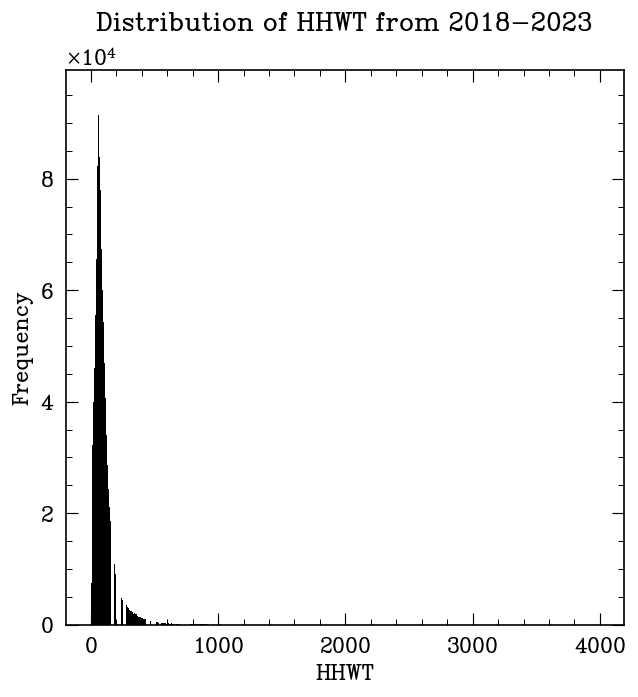

In [17]:
import matplotlib.pyplot as plt 
import smplotlib 

year_array = np.array(table['YEAR']) # do all list operations in numpy for memory efficiency 

mask = (year_array == 2019) # Get True/False for every row if it's YEAR == 2019

# Below three lines to get selections 
mask_more_than_18 = (year_array >= 2018)
mask_less_than_20 = (year_array <= 2020)
mask_18_20 = np.logical_and(mask_more_than_18, mask_less_than_20)

# example plotting 

hhwt_all_years = np.array(table['HHWT'])

plt.hist(hhwt_all_years[mask_18_20], bins='auto')
plt.title('Distribution of HHWT from 2018-2023')
plt.xlabel("HHWT")
plt.ylabel("Frequency")

In [ ]:
sum(mask)



3239553

In [5]:
schema = table.schema 
column_names = schema.names
column_names

['YEAR',
 'SAMPLE',
 'SERIAL',
 'CBSERIAL',
 'HHWT',
 'CLUSTER',
 'REGION',
 'STATEFIP',
 'STRATA',
 'GQ',
 'OWNERSHP',
 'OWNERSHPD',
 'HHINCOME',
 'PERNUM',
 'PERWT',
 'AGE',
 'MARST',
 'BPL',
 'BPLD',
 'CITIZEN',
 'YRSUSA1',
 'EDUC',
 'EDUCD',
 'EMPSTAT',
 'EMPSTATD']

### Process is being moved here

`Load Inflaition Data Set`

In [27]:
import pandas as pd

infl = pd.read_csv("inflation_all_regions.csv")

infl = infl[["country", "year", "inflation"]].dropna()

# Convert to numpy for speed
infl_by_region = {}

for region in infl["country"].unique():
    sub = infl[infl["country"] == region].sort_values("year")
    infl_by_region[region] = (
        sub["year"].to_numpy(),
        sub["inflation"].to_numpy()
    )

print("Inflation data prepared.")


Inflation data prepared.


`Region Mapping Function`

In [23]:
import numpy as np

# State → Region mapping
def map_region(state):
    if state in [9,10,11,23,25,33,34,36,42,44,50]:
        return "Northeast"
    if state in [17,18,19,20,26,27,29,31,38,39,46,55]:
        return "Midwest"
    if state in [1,5,12,13,21,22,28,37,40,45,47,48,51,54]:
        return "South"
    return "West"

`Inflaition Experience Function`

In [26]:
def inflation_experience(region, birth_year, survey_year):
    if region not in infl_by_region:
        return np.nan
    
    years, infl_vals = infl_by_region[region]
    
    mask = (years >= birth_year) & (years < survey_year)
    vals = infl_vals[mask]
    
    if len(vals) == 0:
        return np.nan
    
    # Recency weights
    w = np.arange(1, len(vals)+1)
    w = w / w.sum()
    
    return np.sum(vals * w)


`Creating data set`

In [28]:
import pyarrow.dataset as ds

dataset = ds.dataset("/Users/aleskamedrano/Real_Estate_SeminarFall2025/2018-2023.parquet", format="parquet")
#If it doesn't work this is WRONG dataset 

# Columns you need
cols = [
    "YEAR","AGE","BPL","YRSUSA1","OWNERSHP","HHINCOME",
    "STATEFIP","REGION","EDUC","MARST","CITIZEN",
    "EMPSTAT","PERWT","HHWT"
]

# Directory for output (clean parquet dataset)
import os
output_path = "ACS_cleaned_dataset"
os.makedirs(output_path, exist_ok=True)

# Batch scanner
scanner = dataset.to_batches(columns=cols, batch_size=100000)

for batch_num, batch in enumerate(scanner):

    print(f"Processing batch {batch_num}…")
    
    df = batch.to_pandas()

    # Clean missing codes
    df = df.replace({0: None, 9999999: None, 999999: None})

    # Derived variables
    df["birth_year"] = df["YEAR"] - df["AGE"]
    df["immigration_year"] = df["YEAR"] - df["YRSUSA1"]

    # Region name
    df["region_name"] = df["STATEFIP"].apply(map_region)

    # Merge inflation (for survey year)
    # simple lookup
    df["inflation"] = [
        infl_by_region.get(r, ([], []))[1][infl_by_region.get(r, ([], []))[0] == y][0]
        if (r in infl_by_region and y in infl_by_region[r][0])
        else np.nan
        for r, y in zip(df["region_name"], df["YEAR"])
    ]

    # Compute inflation experience
    df["inflation_experience"] = df.apply(
        lambda r: inflation_experience(
            r["region_name"], 
            r["birth_year"], 
            r["YEAR"]
        ),
        axis=1
    )

    # Convert back to Arrow and save
    batch_table = pa.Table.from_pandas(df)
    
    pq.write_table(
        batch_table,
        f"{output_path}/batch_{batch_num}.parquet"
    )

print("All batches processed and saved!")


Processing batch 0…
Processing batch 1…
Processing batch 2…
Processing batch 3…
Processing batch 4…
Processing batch 5…
Processing batch 6…
Processing batch 7…
Processing batch 8…
Processing batch 9…
Processing batch 10…
Processing batch 11…
Processing batch 12…
Processing batch 13…
Processing batch 14…
Processing batch 15…
Processing batch 16…
Processing batch 17…
Processing batch 18…
Processing batch 19…
Processing batch 20…
Processing batch 21…
Processing batch 22…
Processing batch 23…
Processing batch 24…
Processing batch 25…
Processing batch 26…
Processing batch 27…
Processing batch 28…
Processing batch 29…
Processing batch 30…
Processing batch 31…
Processing batch 32…
Processing batch 33…
Processing batch 34…
Processing batch 35…
Processing batch 36…
Processing batch 37…
Processing batch 38…
Processing batch 39…
Processing batch 40…
Processing batch 41…
Processing batch 42…
Processing batch 43…
Processing batch 44…
Processing batch 45…
Processing batch 46…
Processing batch 47…
Pr

`Loading Data`
I wasn't able to load all the batches because again, the information is too much for my computer RAM. So I am gonna look at the data set by year - one at the time. 

`Loading one year ACS data: 2023`

In [6]:
import pyarrow.dataset as ds

# Load the cleaned ACS dataset
final_ds = ds.dataset("ACS_cleaned_dataset", format="parquet")

# Choose which ACS year you want to analyze
YEAR = 2023

# Load only that year (safe for memory)
df = final_ds.to_table(
    filter=ds.field("YEAR") == YEAR
).to_pandas()

print(df.head())
print(df.shape)


   YEAR   AGE  BPL  YRSUSA1  OWNERSHP  HHINCOME  STATEFIP  REGION  EDUC  \
0  2023  86.0    1      NaN       NaN       NaN         1      32   6.0   
1  2023  60.0   25      NaN       NaN       NaN         1      32   6.0   
2  2023  20.0    1      NaN       NaN       NaN         1      32   7.0   
3  2023  13.0   28      NaN       NaN       NaN         1      32   2.0   
4  2023  18.0   17      NaN       NaN       NaN         1      32   6.0   

   MARST  CITIZEN  EMPSTAT  PERWT  HHWT  birth_year  immigration_year  \
0      5      NaN      3.0    6.0   6.0      1937.0               NaN   
1      6      NaN      3.0   27.0  27.0      1963.0               NaN   
2      6      NaN      3.0   47.0  47.0      2003.0               NaN   
3      6      NaN      NaN   11.0  11.0      2010.0               NaN   
4      6      NaN      3.0   57.0  57.0      2005.0               NaN   

  region_name  inflation  inflation_experience  
0       South   0.036554              0.027167  
1       Sout

`Create Homeownership Variable`

In [7]:
df["homeowner"] = (df["OWNERSHP"] == 1).astype(int)


`Inspecting the key variables`

In [8]:
df[["homeowner","inflation_experience","AGE","HHINCOME"]].describe()


,homeowner,inflation_experience,AGE,HHINCOME
count,3.405809e+06,3.376341e+06,3.376341e+06,3.204323e+06
mean,7.162043e-01,2.941610e-02,4.348801e+01,1.297041e+05
std,4.508390e-01,8.625263e-03,2.373689e+01,1.306598e+05
min,0.000000e+00,2.412231e-02,1.000000e+00,-1.680000e+04
25%,0.000000e+00,2.503993e-02,2.300000e+01,5.250000e+04
50%,1.000000e+00,2.716707e-02,4.400000e+01,9.620000e+04
75%,1.000000e+00,3.035113e-02,6.300000e+01,1.600000e+05
max,1.000000e+00,8.797478e-02,9.600000e+01,3.002000e+06


## `Running the Baseline Regression`

In [9]:
import statsmodels.api as sm

X = df[["inflation_experience", "AGE", "HHINCOME"]]
X = sm.add_constant(X)
y = df["homeowner"]

model = sm.OLS(y, X, missing="drop").fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:              homeowner   R-squared:                       0.072
Model:                            OLS   Adj. R-squared:                  0.072
Method:                 Least Squares   F-statistic:                 8.223e+04
Date:                Sun, 16 Nov 2025   Prob (F-statistic):               0.00
Time:                        17:51:07   Log-Likelihood:            -1.6940e+06
No. Observations:             3175210   AIC:                         3.388e+06
Df Residuals:                 3175206   BIC:                         3.388e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.4428 

### The coefficient of Inflaition experience looks very suspicious so I need to inspect the values of it separately

In [56]:
df["inflation_experience"].describe()


KeyError: 'inflation_experience'

`Running Logit regression`

`Adding Controls`

`I think the thoughest part of the research i going to be getting the inflaition experience values right'. Once I have that data I can run the regression model again

`Second Attempt to construct the inflaition experience data set`

In [ ]:
import pandas as pd
import numpy as np
import pyarrow.dataset as ds
import statsmodels.formula.api as smf

# Load your combined regional CPI dataset
infl = pd.read_csv("inflation_all_regions.csv")

#infl.head(8)

,country,year,month,date,value,monthly_inflation_%,inflation
0,Northeast,2004,1,2004-01-01,195.9,NaN,NaN
1,Northeast,2004,2,2004-02-01,196.8,0.459418,NaN
2,Northeast,2004,3,2004-03-01,198.6,0.914634,NaN
3,Northeast,2004,4,2004-04-01,199.4,0.402820,NaN
4,Northeast,2004,5,2004-05-01,199.9,0.250752,NaN
5,Northeast,2004,6,2004-06-01,201.1,0.600300,NaN
6,Northeast,2004,7,2004-07-01,201.0,-0.049727,NaN
7,Northeast,2004,8,2004-08-01,201.0,0.000000,NaN


`Create annual inflaition`

In [ ]:
# Keep only December CPI
infl_dec = infl[infl["month"] == 12].copy()

# Compute annual YoY inflation for each region
infl_dec["annual_inflation"] = infl_dec.groupby("country")["value"].pct_change()

# Final cleaned annual inflation dataset
infl_annual = infl_dec.dropna(subset=["annual_inflation"])[["country", "year", "annual_inflation"]]
#infl_annual.head(8)


,country,year,annual_inflation
23,Northeast,2005,0.035166
35,Northeast,2006,0.029665
47,Northeast,2007,0.038220
59,Northeast,2008,0.007457
71,Northeast,2009,0.028304
83,Northeast,2010,0.015895
95,Northeast,2011,0.029114
107,Northeast,2012,0.018468


`Create Plot to show inflation Time Series for the 4 regions fo interest`

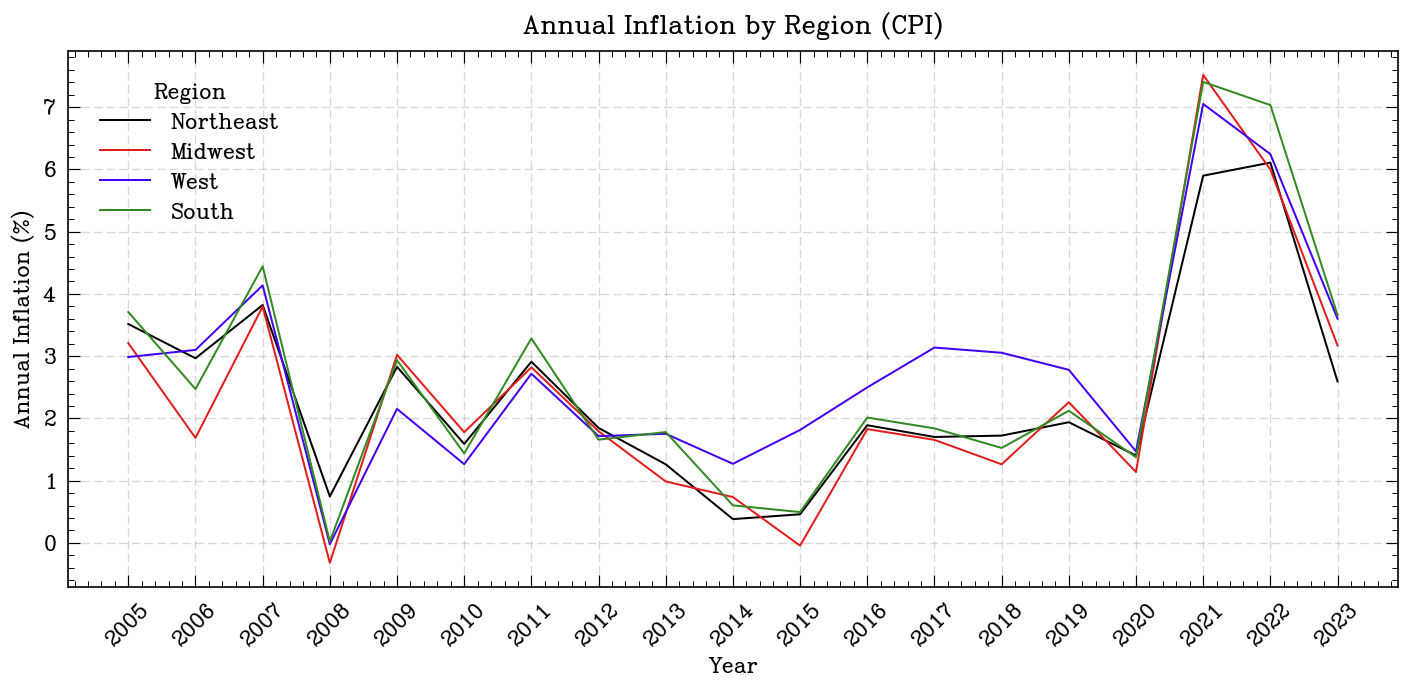

In [ ]:
import matplotlib.pyplot as plt

df = infl_annual.copy()

plt.figure(figsize=(12, 6))

regions = df["country"].unique()

for region in regions:
    subset = df[df["country"] == region]
    plt.plot(subset["year"], subset["annual_inflation"] * 100, label=region)  # convert to %
    
plt.title("Annual Inflation by Region (CPI)")
plt.xlabel("Year")
plt.ylabel("Annual Inflation (%)")
plt.legend(title="Region")

# Force x-axis to show whole years
plt.xticks(
    ticks=sorted(df["year"].unique()),
    labels=sorted(df["year"].unique()),
    rotation=45
)

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("CPI_by_region")
plt.show()




`Home sales overtime`

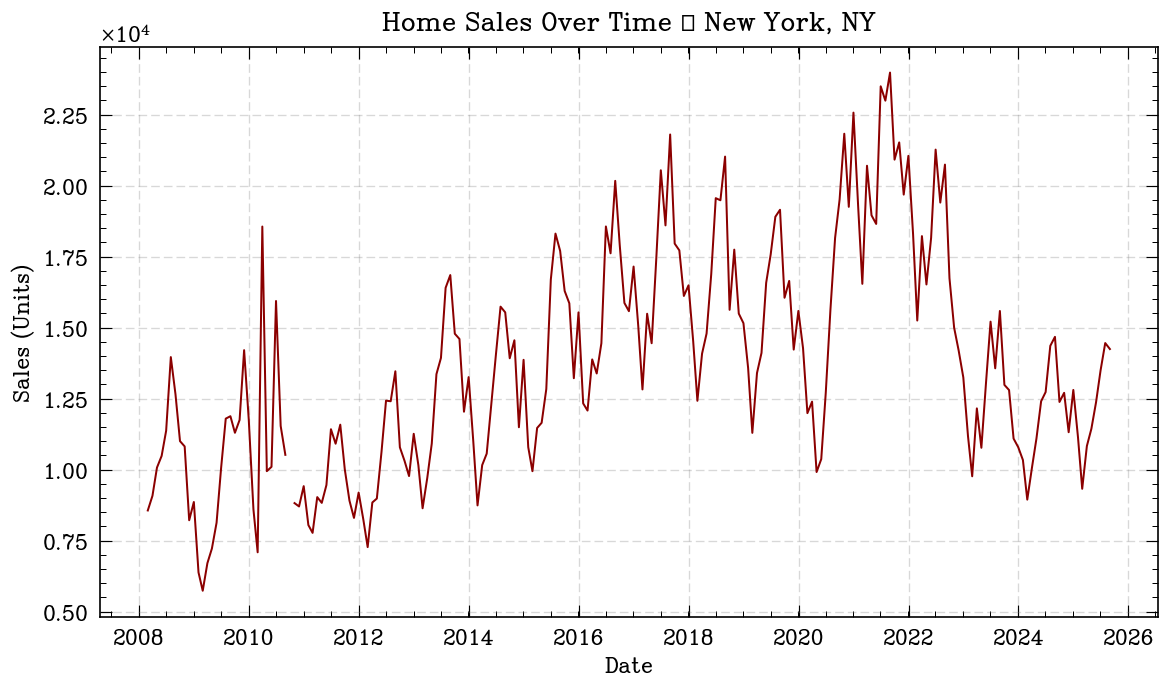

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import smplotlib

df_sales = pd.read_csv("/Users/aleskamedrano/Downloads/Code for posting (Jan. 2024)/Data/sales_zillow_monthly.csv")
#df_sales.head(5)
df_sales_ny = df_sales[df_sales["RegionName"] == "New York, NY"]
#df_sales_ny.head(4)
df_sales_ny.columns

df_sales_long = df_sales_ny.melt(
    id_vars=['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName'],
    var_name='Date',
    value_name='Sales'
)

# Convert Date to datetime
df_sales_long['Date'] = pd.to_datetime(df_sales_long['Date'])

# Sort by Date
df_sales_long = df_sales_long.sort_values('Date')

# Plot
plt.figure(figsize=(10,6))
plt.plot(df_sales_long['Date'], df_sales_long['Sales'], color='darkred')
plt.title(f"Home Sales Over Time — {df_sales_long['RegionName'].iloc[0]}")
plt.xlabel("Date")
plt.ylabel("Sales (Units)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()





`Inflaition Expectation` 
For further research: How accurate are people's expectations predictions vs the actual inflaition levels

Maximum values:
 MICH    10.4
dtype: float64

Minimum values:
 MICH    0.4
dtype: float64

Range (max - min):
 MICH    10.0
dtype: float64


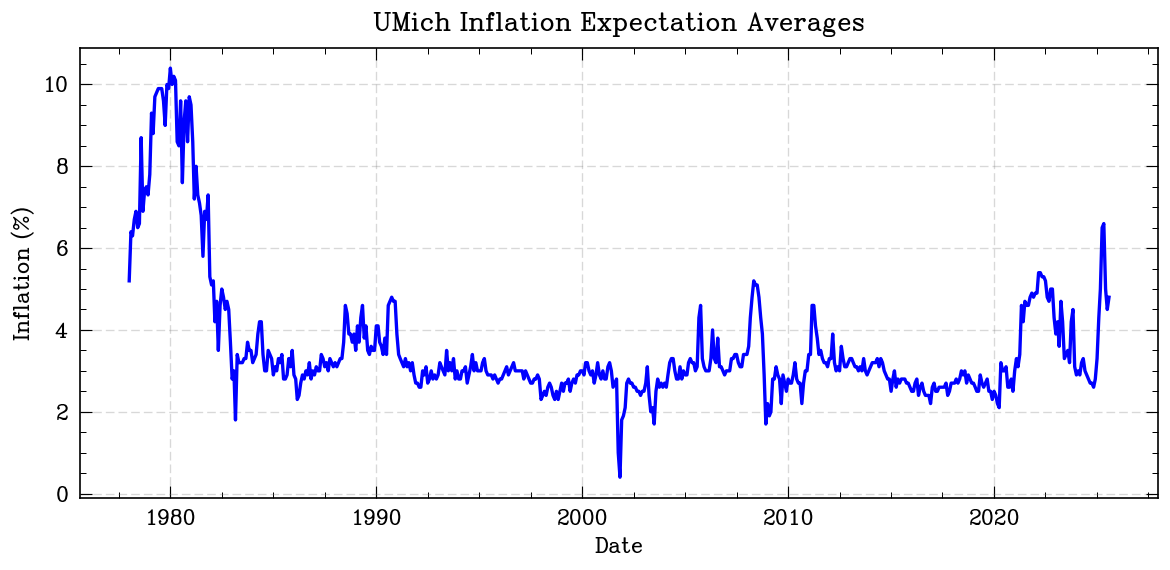

In [57]:
import matplotlib.pyplot as plt
import pandas as pd

# Load dataset
df_inf_exp = pd.read_csv("/Users/aleskamedrano/Downloads/Code for posting (Jan. 2024)/Data/UMich_Inflaition Expectation.csv")

# Compute descriptive stats for numeric columns only
numeric_df = df_inf_exp.select_dtypes(include='number')

maximum = numeric_df.max()
minimum = numeric_df.min()
value_range = maximum - minimum

print("Maximum values:\n", maximum)
print("\nMinimum values:\n", minimum)
print("\nRange (max - min):\n", value_range)

# Convert date column (adjust column name if needed)
df_inf_exp['Date'] = pd.to_datetime(df_inf_exp['observation_date'])

# Plot inflation expectations
plt.figure(figsize=(10,5))
plt.plot(df_inf_exp['Date'], df_inf_exp['MICH'], color='blue', linewidth=2)
plt.title("UMich Inflation Expectation Averages")
plt.xlabel("Date")
plt.ylabel("Inflation (%)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()



`Household Income levels for each region`

In [59]:
import pyarrow.dataset as ds
import pandas as pd

dataset = ds.dataset("/Users/aleskamedrano/Real_Estate_SeminarFall2025/2018-2023.parquet")

# Load all years (safe because we only keep a few columns!)
acs = dataset.to_table(columns=["YEAR", "HHINCOME", "REGION"]).to_pandas()

# Map REGION → REGION_NAME (your corrected mapping)
region_map = {
    11: "Northeast", 12: "Northeast",
    21: "Midwest",   22: "Midwest",
    31: "South",     32: "South", 33: "South",
    41: "West",      42: "West"
}

acs["REGION_NAME"] = acs["REGION"].map(region_map)


In [61]:
acs = acs.dropna(subset=["HHINCOME"])
acs = acs[acs["HHINCOME"] >= 0]

print(acs)


          YEAR  HHINCOME  REGION REGION_NAME
0         2019   9999999      32       South
1         2019   9999999      32       South
2         2019   9999999      32       South
3         2019   9999999      32       South
4         2019   9999999      32       South
...        ...       ...     ...         ...
15912388  2023    145000      41        West
15912389  2023    145000      41        West
15912390  2023     75000      41        West
15912391  2023     43600      41        West
15912392  2023     43600      41        West

[15907295 rows x 4 columns]


In [63]:
income_by_region_year = (
    acs.groupby(["YEAR", "REGION_NAME"])["HHINCOME"]
       .mean()
       .reset_index()
)
income_by_region_year.head()


,YEAR,REGION_NAME,HHINCOME
0,2019,Midwest,563329.783105
1,2019,Northeast,678258.669343
2,2019,South,554871.467497
3,2019,West,527593.639877
4,2020,Midwest,764179.561994


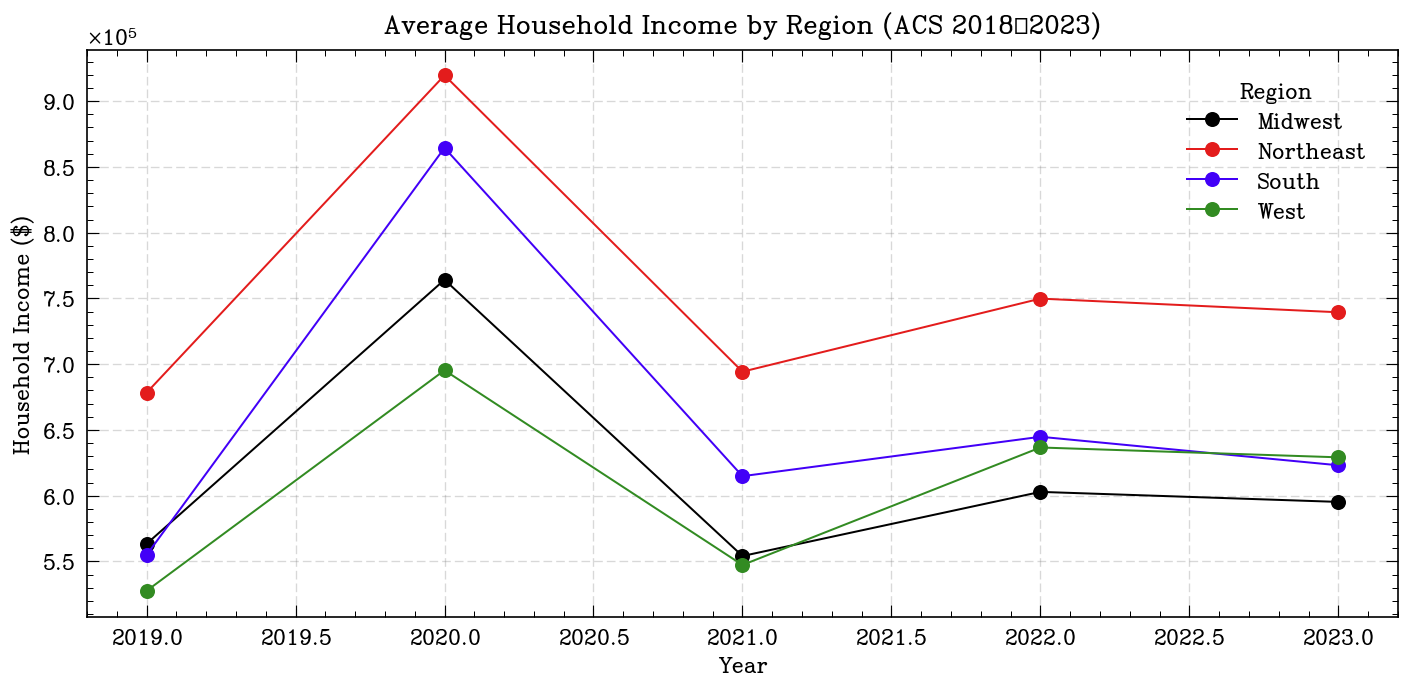

In [65]:
import matplotlib.pyplot as plt
import smplotlib

plt.figure(figsize=(12, 6))

regions = income_by_region_year["REGION_NAME"].unique()

for region in regions:
    subset = income_by_region_year[income_by_region_year["REGION_NAME"] == region]
    plt.plot(subset["YEAR"], subset["HHINCOME"], marker="o", label=region)

plt.title("Average Household Income by Region (ACS 2018–2023)")
plt.xlabel("Year")
plt.ylabel("Household Income ($)")
plt.legend(title="Region")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


`Load data for 2023`

In [ ]:
dataset = ds.dataset("/Users/aleskamedrano/Real_Estate_SeminarFall2025/2018-2023.parquet")

acs = dataset.to_table(
    filter=ds.field("YEAR") == 2023
).to_pandas()


`Prepare ACS Variable`

In [ ]:
acs["birth_year"] = acs["YEAR"] - acs["AGE"]
#Region
region_map = {
    1: "Northeast",
    2: "Midwest",
    3: "South",
    4: "West"
}

acs["REGION_NAME"] = acs["REGION"].map(region_map)

#Homeownership Indicator:
acs["homeowner"] = (acs["OWNERSHP"] == 1).astype(int)


`Function to compute inflation experience (exact formula) like in the paper`

In [ ]:
def compute_experience(row, infl_annual):
    region = row["REGION_NAME"]
    birth_year = int(row["birth_year"])
    #Max data available for the year (2019-2023), where I weigth the recent years as the highet and the 2019 the lowest
    survey_year = int(row["YEAR"])

    # Inflation from birth until year before survey
    low = birth_year
    high = survey_year - 1

    subset = infl_annual[
        (infl_annual["country"] == region) &
        (infl_annual["year"] >= low) &
        (infl_annual["year"] <= high)
    ].sort_values("year")

    if subset.empty:
        return np.nan

    infl_vals = subset["annual_inflation"].values
    n = len(infl_vals)

    # Recency weights (linear decline)
    weights = np.arange(1, n+1)[::-1]

    return np.average(infl_vals, weights=weights)


`Applying the inflation experience formula to the ACS data set`

In [67]:
acs["inflation_experience"] = acs.apply(
    compute_experience,
    axis=1,
    infl_annual=infl_annual
)


KeyError: 'birth_year'

In [ ]:
acs.head(50)


,YEAR,SAMPLE,SERIAL,CBSERIAL,HHWT,CLUSTER,REGION,STATEFIP,STRATA,GQ,...,YRSUSA1,EDUC,EDUCD,EMPSTAT,EMPSTATD,birth_year,REGION_NAME,homeowner,inflation_experience,log_infl_exp
0,2023,202301,1,2023010000113,6.0,2023000000011,32,1,280201,3,...,0,6,63,3,30,1937,NaN,0,NaN,NaN
1,2023,202301,2,2023010000180,27.0,2023000000021,32,1,10001,3,...,0,6,63,3,30,1963,NaN,0,NaN,NaN
2,2023,202301,3,2023010000181,47.0,2023000000031,32,1,40201,4,...,0,7,71,3,30,2003,NaN,0,NaN,NaN
3,2023,202301,4,2023010000250,11.0,2023000000041,32,1,270201,3,...,0,2,26,0,0,2010,NaN,0,NaN,NaN
4,2023,202301,5,2023010000340,57.0,2023000000051,32,1,280201,4,...,0,6,65,3,30,2005,NaN,0,NaN,NaN
5,2023,202301,6,2023010000364,52.0,2023000000061,32,1,120201,4,...,0,7,71,3,30,2004,NaN,0,NaN,NaN
6,2023,202301,7,2023010000493,43.0,2023000000071,32,1,180101,3,...,0,5,50,3,30,1986,NaN,0,NaN,NaN
7,2023,202301,8,2023010000537,1.0,2023000000081,32,1,140201,4,...,0,10,101,3,30,1952,NaN,0,NaN,NaN
8,2023,202301,9,2023010000558,3.0,2023000000091,32,1,140401,4,...,0,10,101,3,30,1948,NaN,0,NaN,NaN
9,2023,202301,10,2023010000796,41.0,2023000000101,32,1,280201,4,...,0,7,71,1,10,2004,NaN,0,NaN,NaN


In [ ]:
acs["log_infl_exp"] = np.log(acs["inflation_experience"])


`Run Base Line Regression`

In [ ]:
logit_model = smf.logit(
    "homeowner ~ log_infl_exp + AGE + HHINCOME",
    data=acs
).fit()

print(logit_model.summary())



ValueError: zero-size array to reduction operation maximum which has no identity